# **Libraries**

Import semua library yang dibutuhkan.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium import plugins
import geopandas as gpd


In [2]:
import warnings
warnings.filterwarnings('ignore')

# **Data**

Import *dataset london_crime_by_lsoa.csv* ke dalam variabel **data**.

In [3]:
data = pd.read_csv("london_crime_by_lsoa.csv")
data.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


Buatlah salinan dari **data** dan beri nama **london_crime**, sehingga jika ada perubahan tidak akan mempengaruhi *dataset* asli.

In [4]:
london_crime = data.copy()

Periksa, apakah ada nilai null dalam *dataset*.

In [5]:
london_crime.isnull().sum()

lsoa_code         0
borough           0
major_category    0
minor_category    0
value             0
year              0
month             0
dtype: int64

Menampilkan seluruh nama wilayah yang ada di London.

In [6]:
london_crime['borough'].unique()

array(['Croydon', 'Greenwich', 'Bromley', 'Redbridge', 'Wandsworth',
       'Ealing', 'Hounslow', 'Newham', 'Sutton', 'Haringey', 'Lambeth',
       'Richmond upon Thames', 'Hillingdon', 'Havering',
       'Barking and Dagenham', 'Kingston upon Thames', 'Westminster',
       'Hackney', 'Enfield', 'Harrow', 'Lewisham', 'Brent', 'Southwark',
       'Barnet', 'Waltham Forest', 'Camden', 'Bexley',
       'Kensington and Chelsea', 'Islington', 'Tower Hamlets',
       'Hammersmith and Fulham', 'Merton', 'City of London'], dtype=object)

Buat kolom baru dan beri nama **date** dengan menggabungkan kolom **year** dan **month**, lalu ubah menjadi *datetime*.

In [7]:
date = []
for i,j in zip(london_crime["month"],london_crime["year"]):
    date.append(f"{i} {j}")
    
london_crime["date"] = date
london_crime["date"] = pd.to_datetime(london_crime["date"])
london_crime.head()

,lsoa_code,borough,major_category,minor_category,value,year,month,date
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,2016-11-01
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,2016-11-01
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,2015-05-01
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,2016-03-01
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,2008-06-01


Hapus kolom yang tidak perlu dan tetapkan **date** sebagai *index*.

In [8]:
london_crime = london_crime.sort_values("date")
london_crime = london_crime.drop(["lsoa_code","year","month"],axis=1)
london_crime = london_crime.set_index("date")
london_crime.head()

,borough,major_category,minor_category,value
date,,,,
2008-01-01,Barking and Dagenham,Burglary,Burglary in Other Buildings,3
2008-01-01,Redbridge,Criminal Damage,Criminal Damage To Dwelling,0
2008-01-01,Barnet,Drugs,Drug Trafficking,0
2008-01-01,Hammersmith and Fulham,Violence Against the Person,Common Assault,0
2008-01-01,Barking and Dagenham,Sexual Offences,Other Sexual,0


# **Line Plot - Tahun Berapa yang Memiliki Tingkat Kejahatan Terendah?**

Buat sebuah *dataframe* baru dan beri nama **sum_per_year** yang terdiri dari jumlah kejahatan per tahun.

In [9]:
sum_per_year = london_crime.groupby(london_crime.index.year)[["value"]].sum()
sum_per_year.head()

,value
date,
2008,738641
2009,717214
2010,715324
2011,724915
2012,737329


Buat **Line Plot** untuk memvisualisasikan jumlah kejahatan berdasarkan tahun.

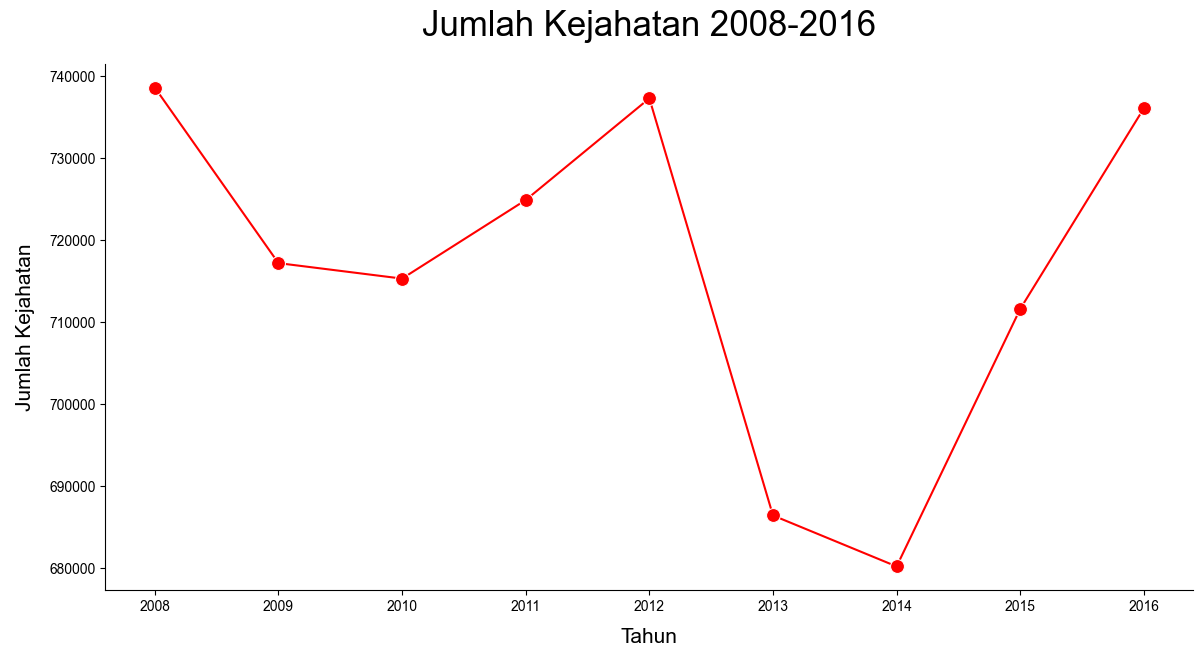

In [10]:
sns.relplot(x="date", y="value", 
            data=sum_per_year, kind="line", 
            ci=None, height=6, aspect=2,
            color='red', marker='o',markersize=10)
sns.set_style("darkgrid")
plt.title('Jumlah Kejahatan 2008-2016',size=25,pad=20)
plt.xlabel('Tahun',size=15,labelpad=10)
plt.ylabel('Jumlah Kejahatan',size=15,labelpad=10)
plt.show()

**Kesimpulan:** Berdasarkan grafik di atas, dapat disimpulkan bahwa pada tahun 2008, 2012, dan 2016 merupakan tahun dengan tingkat kejahatan yang sangat tinggi. Lalu terdapat penurunan yang sangat drastis pada tahun 2013 dan terdapat kenaikan yang sangat drastis pada tahun 2015 diikuti tahun 2016. Terlihat juga pada grafik di atas bahwa tahun 2014 merupakan tahun paling aman, karena memiliki tingkat kejahatan yang paling rendah diantara yang lain.

# **Area Plot - Bagaimana Tren Kejahatan yang Terjadi di 5 Wilayah dengan Tingkat Kejahatan Tertinggi dari Tahun 2008-2016?**

5 wilayah dengan tingkat kejahatan tertinggi, yaitu:
- Westminter
- Lambeth
- Southwark
- Camden
- Newham

Buat sebuah *variabel* yang hanya berisi 5 wilayah dengan tingkat kejahatan tertinggi, lalu jumlahkan tingkat kejahatan di setiap wilayah dan tahun.

In [11]:
top5_borough = london_crime.groupby('borough')[['value']].sum().sort_values('value',ascending=False).head().index
top5_borough

Index(['Westminster', 'Lambeth', 'Southwark', 'Camden', 'Newham'], dtype='object', name='borough')

Buat sebuah *dataframe* baru dan beri nama **top_5** yang terdiri dari jumlah kejahatan per tahun.

In [12]:
top5 = london_crime[london_crime['borough'].isin(top5_borough)][['borough','value']]
top5 = top5.groupby(['borough',top5.index.year])[['value']].sum().reset_index()
top5.head()

,borough,date,value
0,Camden,2008,32010
1,Camden,2009,31612
2,Camden,2010,31804
3,Camden,2011,33956
4,Camden,2012,31472


Buat *dataframe* yang berisi **date** sebagai *index* dan 5 wilayah tertinggi sebagai *column* serta **value** sebagai *values* dari *dataframe* tersebut. Hal ini dilakukan untuk mempermudah dalam pembuatan **Area Plot**.

In [13]:
top5_area=top5.pivot_table(values='value', index='date', columns='borough')
top5_area

borough,Camden,Lambeth,Newham,Southwark,Westminster
date,,,,,
2008,32010.0,31717.0,29752.0,33470.0,47846.0
2009,31612.0,31225.0,28610.0,30623.0,48456.0
2010,31804.0,31671.0,30728.0,31320.0,48116.0
2011,33956.0,33224.0,27978.0,30723.0,54243.0
2012,31472.0,33473.0,30067.0,30737.0,59226.0
2013,28435.0,31868.0,27577.0,31128.0,53852.0
2014,27198.0,31765.0,28005.0,28912.0,47564.0
2015,29477.0,33164.0,29217.0,30260.0,47395.0
2016,29183.0,34071.0,30090.0,31636.0,48330.0


Buat **Area Plot** untuk memvisualisasikan tren kejahatan di Camden, Lambeth, Newham, Southwark, dan Westminster dari tahun 2008-2016.

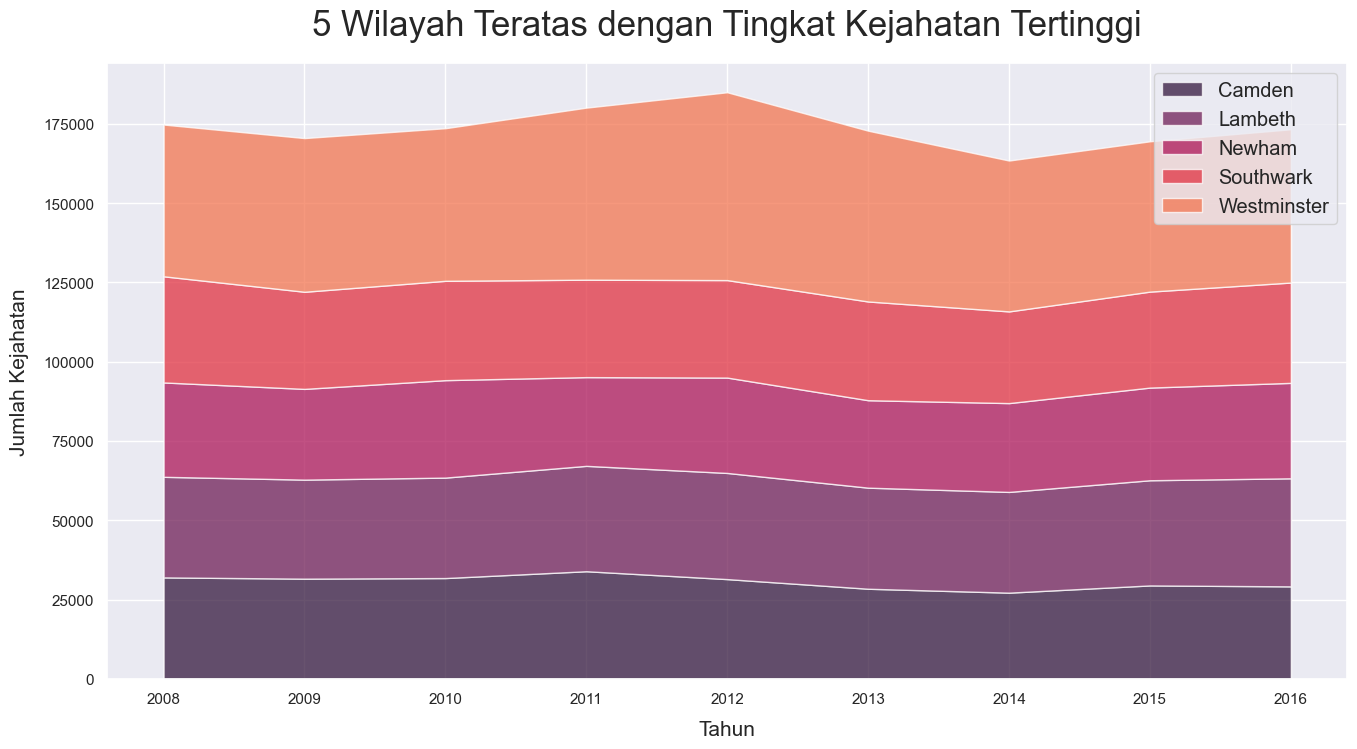

In [14]:
sns.set_theme()
sns.set_palette("rocket")
plt.figure(figsize=(16, 8))
plt.stackplot(top5_area.index,top5_area.Camden,top5_area.Lambeth,
              top5_area.Newham,top5_area.Southwark,top5_area.Westminster,
              alpha=0.75,labels=['Camden','Lambeth','Newham','Southwark','Westminster'])
plt.title('5 Wilayah Teratas dengan Tingkat Kejahatan Tertinggi',size=25,pad=20)
plt.xlabel('Tahun',size=15,labelpad=10)
plt.ylabel('Jumlah Kejahatan',size=15,labelpad=10)
plt.legend(fontsize='large')
plt.show()

**Kesimpulan:** Berdasarkan grafik di atas, dapat disimpulkan bahwa semua wilayah memiliki tren fluktuasi yang sama. Kejahatan tertinggi terjadi pada tahun 2012. Terlihat juga bahwa Westminster memiliki area paling luas sehingga dapat dikatakan bahwa Westminster merupakan wilayah dengan tingkat kejahatan tertinggi.

# **Scatter Plot - Bagaimana Pola Data dari Jumlah Kejahatan Berdasarkan Bulan?**

Buat sebuah *dataframe* baru bernama **value_per_month** yang berisi jumlah kejahatan per bulan.

In [15]:
value_per_month = london_crime.groupby('date')[["value"]].sum().reset_index()

Buat **Scatter Plot** untuk memvisualisasikan pola data dari jumlah kejahatan berdasarkan bulan.

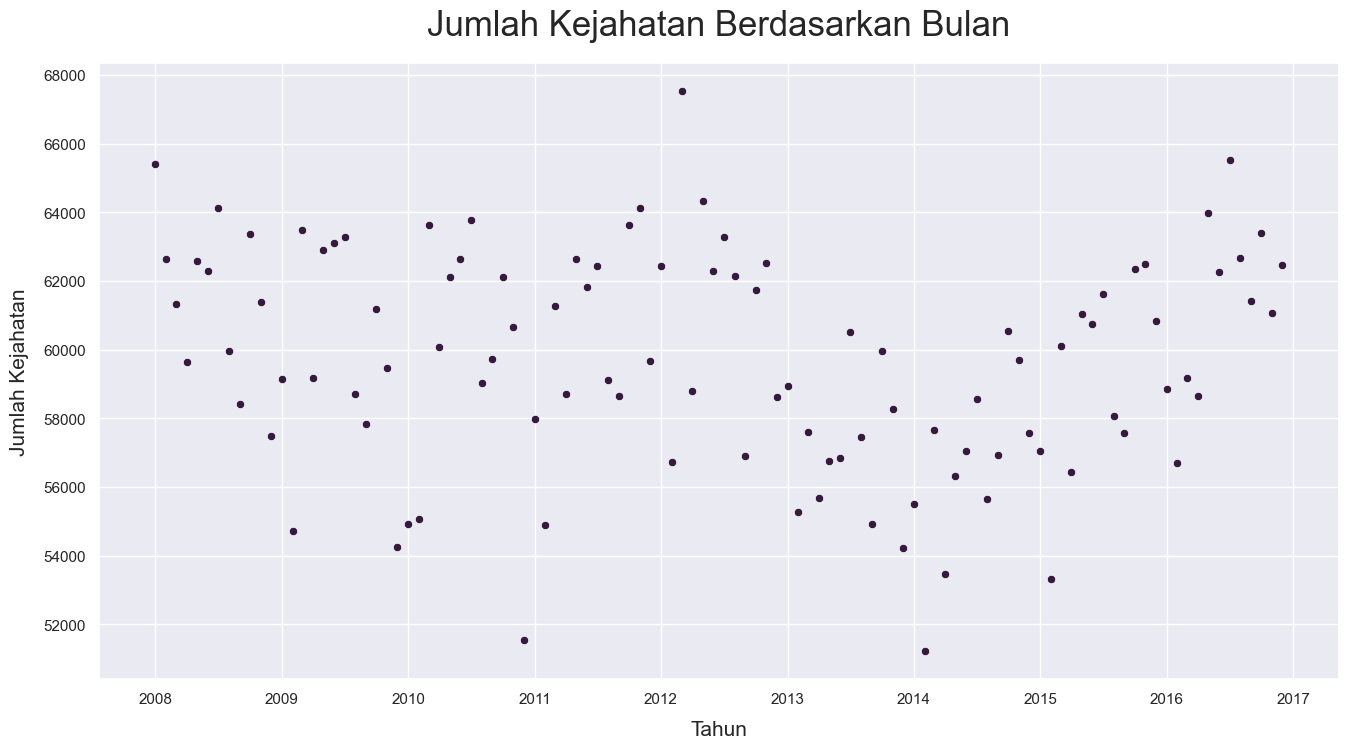

In [16]:
plt.figure(figsize=(16, 8))
sns.scatterplot(value_per_month, x="date", y="value")
plt.title('Jumlah Kejahatan Berdasarkan Bulan',size=25,pad=20)
plt.xlabel('Tahun',size=15,labelpad=10)
plt.ylabel('Jumlah Kejahatan',size=15,labelpad=10)
plt.show()

**Kesimpulan:** Berdasarkan grafik di atas, dapat disimpulkan bahwa sebaran data acak atau tidak membentuk pola tertentu.

# **Box Plot - Apakah Terdapat Outlier Pada Tingkat Kejahatan di Wilayah Westminster?**

Buat sebuah *dataframe* baru bernama **westminster_box** yang berisi **value** untuk wilayah Westmister saja.

In [17]:
westminster_box = london_crime[london_crime['borough']=='Westminster'][['value']].resample('M').sum()

Buat **Box Plot** untuk mendeteksi ada atau tidaknya outlier.

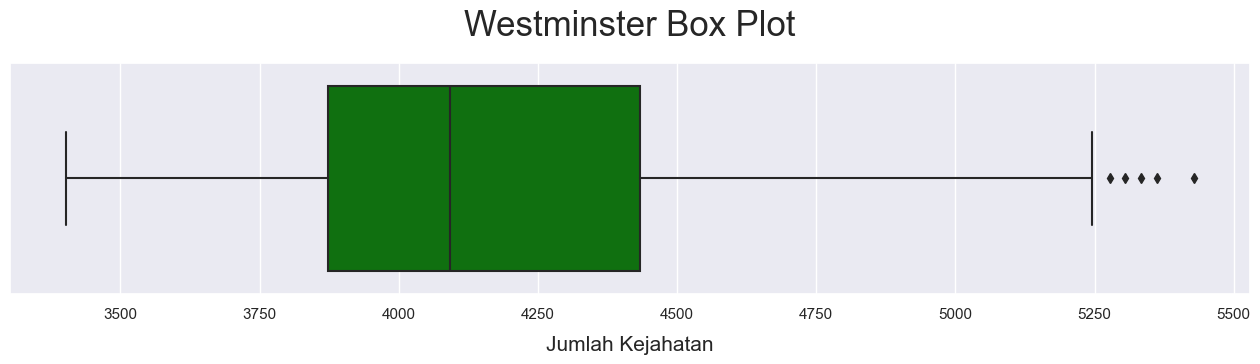

In [18]:
plt.figure(figsize=(16, 3))
sns.boxplot(westminster_box, x="value",color='green')
plt.title('Westminster Box Plot',size=25,pad=20)
plt.xlabel('Jumlah Kejahatan',size=15,labelpad=10)
plt.show()

**Kesimpulan:** Berdasarkan grafik di atas, dapat disimpulkan bahwa data cenderung miring ke kanan (*positive skewness*), hal itu ditunjukkan dengan letak garis median tidak berada di tengah kotak dan whisker kanan lebih panjang daripada whisker kiri serta terdapat outlier di bagian kanan berjumlah 5.

# **Histogram - Bagaimana Tingkat Kejahatan di Wilayah Westminster Terdistribusi di Sepanjang Rentang Nilai-nilainya?**

Buat sebuah *dataframe* baru bernama **westminster_box** yang berisi **value** untuk wilayah Westmister saja.

In [19]:
westminster_hist = london_crime[london_crime['borough']=='Westminster'][['value']].resample('M').sum()

Buat **Histogram** untuk mendeteksi distribusi yang terjadi.

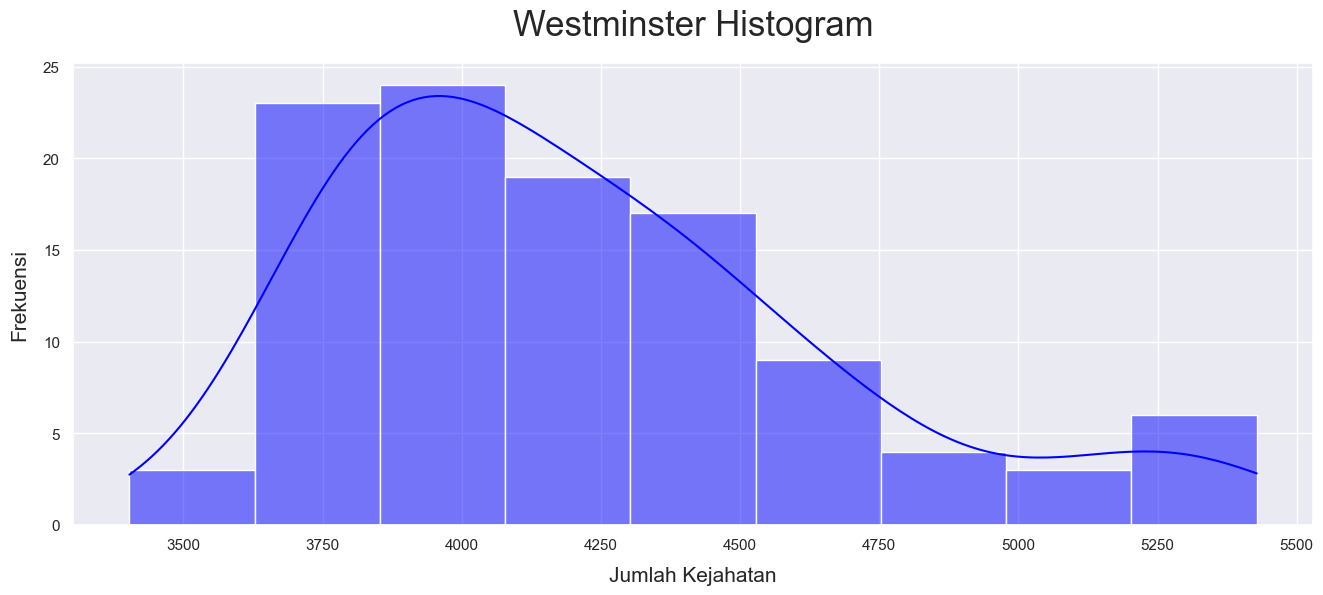

In [20]:
plt.figure(figsize=(16, 6))
sns.histplot(westminster_hist, x="value",color='blue',kde=True)
plt.title('Westminster Histogram',size=25,pad=20)
plt.xlabel('Jumlah Kejahatan',size=15,labelpad=10)
plt.ylabel('Frekuensi',size=15,labelpad=10)
plt.show()

**Kesimpulan:** Berdasarkan grafik di atas, dapat disimpulkan bahwa distribusi cenderung miring ke kanan (*positive skewness*), karena ekor kanan lebih panjang daripada ekor kiri. Hal ini berarti sebagian nilai-nilai distibusi terjadi di sisi kiri.

# **Bar Chart - Kategori Kejahatan Apa yang Paling Sering Terjadi di 5 Wilayah dengan Tingkat Kejahatan Tertinggi?**

Buat sebuah *dataframe* baru dan beri nama **borough_major** yang terdiri dari jumlah kejahatan berdasarkan wilayah dan kategori utama.

In [21]:
borough_major = london_crime.groupby(["borough","major_category"])[["value"]].sum()
borough_major = borough_major.reset_index()
borough_major = borough_major.sort_values("value",ascending=False)
borough_major.head()

,borough,major_category,value
293,Westminster,Theft and Handling,277617
52,Camden,Theft and Handling,140596
194,Lambeth,Theft and Handling,114899
248,Southwark,Theft and Handling,109432
167,Islington,Theft and Handling,107661


Buat *variabel* yang masing-masing berisi 5 wilayah dengan tingkat kejahatan tertinggi.

In [22]:
top5_westminster=borough_major[borough_major['borough']=='Westminster']
top5_camden=borough_major[borough_major['borough']=='Camden']
top5_lambeth=borough_major[borough_major['borough']=='Lambeth']
top5_southwark=borough_major[borough_major['borough']=='Southwark']
top5_newham=borough_major[borough_major['borough']=='Newham']

Buat 'dataframe' bernama **top5_all** yang berisi gabungan dari 5 wilaayah tadi. Hal ini dilakukan untuk mempermudah dalam pembuatan **Bar Chart**.

In [23]:
top5_all=pd.concat([top5_westminster, top5_camden],ignore_index=True)
top5_all=pd.concat([top5_all, top5_lambeth],ignore_index=True)
top5_all=pd.concat([top5_all, top5_southwark],ignore_index=True)
top5_all=pd.concat([top5_all, top5_newham],ignore_index=True)
top5_all

,borough,major_category,value
0,Westminster,Theft and Handling,277617
1,Westminster,Violence Against the Person,71448
2,Westminster,Drugs,34031
3,Westminster,Burglary,29295
4,Westminster,Criminal Damage,20405
5,Westminster,Robbery,15752
6,Westminster,Other Notifiable Offences,6148
7,Westminster,Fraud or Forgery,273
8,Westminster,Sexual Offences,59
9,Camden,Theft and Handling,140596


Buat **Bar Chart** untuk memvisualisasikan Jumlah Kejahatan berdasarkan wilayah dan juga kategori utama.

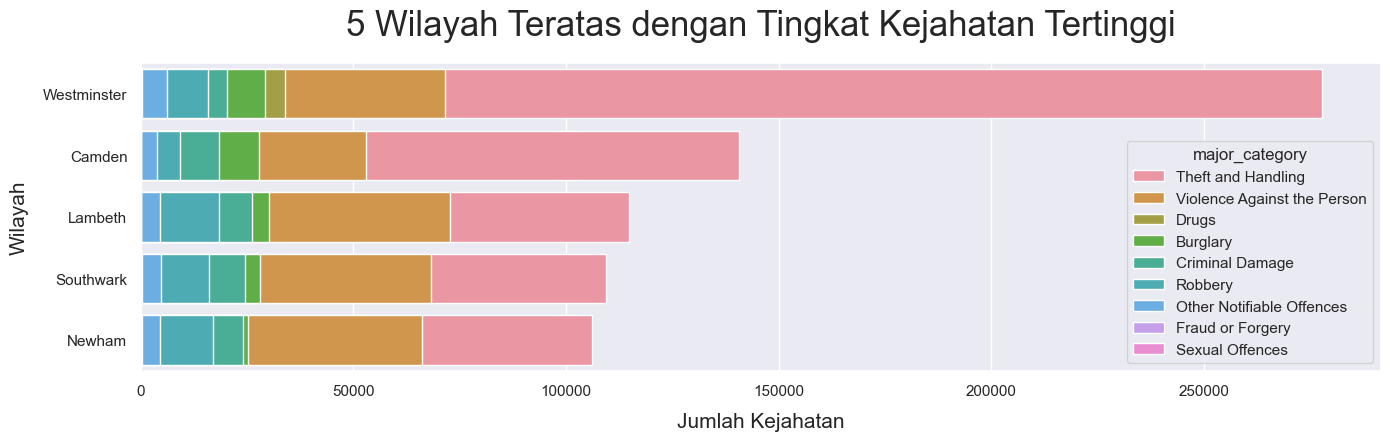

In [24]:
plt.figure(figsize=(16, 4))
sns.barplot(top5_all,x="value",y="borough",
            errorbar=None,hue='major_category',
            dodge=False)
plt.title('5 Wilayah Teratas dengan Tingkat Kejahatan Tertinggi',size=25,pad=20)
plt.xlabel('Jumlah Kejahatan',size=15,labelpad=10)
plt.ylabel('Wilayah',size=15,labelpad=10)
plt.show()

**Kesimpulan:** Berdasarkan diagram batang di atas, dapat disimpulkan bahwa Westminster memiliki jumlah kejahatan paling banyak. Lalu kategori *Theft and Handling* merupakan kategori kejahatan yang paling sering terjadi, karena dapat dilihat bahwa kategori tersebut mendominasi diagram.

# **Pie Chart - Kejahatan Apa yang Memiliki Persentase Tertinggi pada Kategori Utama?**

Buat sebuah dataframe baru, dan beri nama **major** yang terdiri dari jumlah kejahatan berdasarkan kategori utama. Lalu kategori *Other Notifiable Offences, Fraud or Forgery, dan Sexual Offences* digabung menjadi satu dengan nama **Others**. Hal itu dilakukan, karena ketiga kategori tersebut memiliki nilai yang sangat kecil sehingga lebih baik digabung menjadi satu saja agar lebih mudah dilihat.

In [25]:
major = london_crime.groupby("major_category")[["value"]].sum()
major = major.sort_values("value",ascending=False)
major = major.reset_index()

combined_categories = major.iloc[6:].sum().value
baris_baru = pd.Series({"major_category" :'Others','value':combined_categories})
major = pd.concat([major, baris_baru.to_frame().T],ignore_index=True)
major = major.drop(range(6,9))
major = major.reset_index(drop=True)
major

,major_category,value
0,Theft and Handling,2661861
1,Violence Against the Person,1558081
2,Burglary,754293
3,Criminal Damage,630938
4,Drugs,470765
5,Robbery,258873
6,Others,112947


Buat **Pie Chart** untuk memvisualisasikan persentase kejahatan berdasarkan **Kategori Utama**.

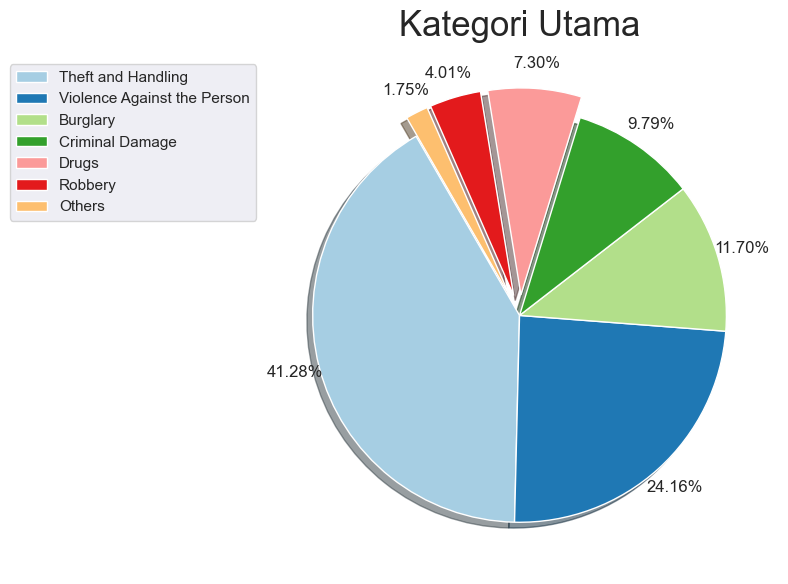

In [26]:
sns.set_theme()
sns.set_palette('Paired')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.pie(major["value"],labels=None,
        autopct='%1.2f%%',pctdistance=1.12,
        shadow=True,explode=[0,0,0,0,0.1,0.1,0.1],startangle=120)
plt.legend(labels=major['major_category'],
           loc='upper left',bbox_to_anchor=(-0.5, 1))
plt.title('Kategori Utama',size=25,pad=15)
plt.tight_layout()
plt.show()

**Kesimpulan:** Berdasarkan diagram lingkaran di atas, dapat dilihat bahwa kategori *Theft and Handling* memiliki persentase tertinggi sebesar 41,28% diikuti oleh kategori *Violence Against the Person* sebesar 24,16% untuk kategori utama.

# **Word Clouds - Kata Apa yang Paling Sering Muncul dalam Kategori Minoritas?**

Buat *variabel* bernama **teks** yang berisi semua kata yang ada pada kategori minoritas.

In [27]:
teks = " ".join(london_crime['minor_category'].unique())

Buat mask berbentuk lingkaran.

In [28]:
x,y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 150 ** 2
mask = 255 * mask.astype(int)

Buat **Word Clouds** untuk menemukan kata yang paling sering muncul dalam kategori minoritas.

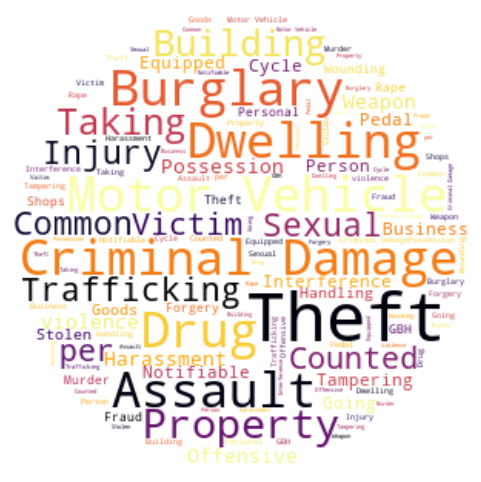

In [29]:
plt.figure(figsize=(6,6))
crimes_wordcloud = WordCloud(background_color="white", colormap='inferno',
                             collocations=True, repeat=True, mask=mask)
crimes_wordcloud.generate(teks)

plt.imshow(crimes_wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

**Kesimpulan:** Berdasarkan gambar di atas, dapat disimpulkan bahwa kategori minoritas didominasi oleh kata-kata seperti Theft, Dwelling, Drug, Assault, dan lain-lain.

# **Folium Maps dan Choropleth Maps - Bagaimana Kejahatan di London Secara Umum?**

## **Folium Maps**

Buat *dataset* bernama **borough_order** yang berisi wilayah dan value serta diurutkan berdasarkan value.

In [30]:
borough_order = london_crime.groupby('borough')['value'].sum()
borough_order = borough_order.reset_index()
borough_order = borough_order.sort_values('value',ascending=False)
borough_order.head()

,borough,value
32,Westminster,455028
21,Lambeth,292178
27,Southwark,278809
5,Camden,275147
24,Newham,262024


Ubah dan tambahkan kata *London* pada nama wilayah *Camden, Bexley, Brent, Sutton, Waltham Forest, dan Tower Hamlets*. Hal ini dilakukan agar lebih akurat dalam menemukan latidude dan longitude pada wilayah tersebut. 

In [31]:
borough_order['borough'] = borough_order['borough'].replace({'Camden': 'Camden London',
                                                            'Bexley': 'Bexley London',
                                                            'Brent': 'Brent London',
                                                            'Sutton': 'Sutton London',
                                                            'Waltham Forest': 'Waltham Forest London',
                                                            'Tower Hamlets':'Tower Hamlets London'})

Temukan latitude dan longitude untuk setiap wilayah.

In [32]:
geolocator = Nominatim(user_agent="myGeocoder")

latitude,longitude = ([] for i in range(2))
for i in borough_order["borough"]:
    location = geolocator.geocode(i,timeout=None)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

Buat *variabel* bernama **temp_borough** yang berisi seluruh wilayah yang ada.

In [33]:
temp_borough = []
for i in borough_order["borough"]:
    temp_borough.append(borough_order[borough_order["borough"] == i])

Masukkan latitude dan longitude setiap wilayah ke dalam **temp_borough**.

In [34]:
for i,j,k in zip(temp_borough,latitude,longitude):
    i.insert(1,"latitude",j)
    i.insert(2,"longitude",k)

Gabungkan semuanya dan urutkan berdasarkan *index*.

In [35]:
borough_coordinate = pd.concat(temp_borough)
borough_coordinate = borough_coordinate.sort_index()
borough_coordinate.head()

,borough,latitude,longitude,value
0,Barking and Dagenham,51.554091,0.150489,149447
1,Barnet,51.653090,-0.200226,212191
2,Bexley London,51.441679,0.150488,114136
3,Brent London,51.576760,-0.218380,227551
4,Bromley,51.366857,0.061709,184349


Cari latitude and longitude dari London.

In [36]:
london = geolocator.geocode("London",timeout=None)
london.latitude,london.longitude

(51.4893335, -0.14405508452768728)

Membuat **Folium Map** untuk menunjukkan jumlah kejahatan dan wilayahnya.

In [37]:
london_map = folium.Map(location=[london.latitude,london.longitude],zoom_start=10)

crimes = plugins.MarkerCluster().add_to(london_map)
for i,j,k in zip(borough_coordinate["latitude"],
                 borough_coordinate["longitude"],
                 borough_coordinate["borough"]):
    folium.Marker(location=[i,j],
                  popup=k).add_to(crimes)
    
colormap = plugins.HeatMap(borough_coordinate[['latitude', 'longitude', 'value']],
                           gradient={0.2: 'blue', 0.4: 'green', 0.6: 'yellow', 0.8: 'orange', 1: 'red'},
                           radius=15)
colormap.add_to(london_map)

london_map

**Kesimpulan:** Berdasarkan peta di atas, dapat dilihat bahwa kejahatan tersebar merata di London.

## **Choropleth Maps**

Unduh file GeoJSON yang mendefinisikan wilayah di London.

In [38]:
from urllib.request import urlopen
import json
with urlopen("https://skgrange.github.io/www/data/london_boroughs.json") as response:
    london_boroughs = json.load(response)

Dapatkan ID untuk setiap wilayah dari file GeoJSON.

In [39]:
boroughs_id = {}
for i in london_boroughs["features"]:
    i["id"] = i["properties"]["id"]
    boroughs_id[i["properties"]["name"]] = i["id"]

Tambahkan dan cocokkan ID wilayah yang relevan di dalam *dataframe*.

In [40]:
borough_crimes = london_crime.groupby("borough")[["value"]].sum().reset_index()
borough_crimes["id"] = borough_crimes["borough"].apply(lambda x: boroughs_id[x])
borough_crimes.head()

,borough,value,id
0,Barking and Dagenham,149447,32
1,Barnet,212191,10
2,Bexley,114136,15
3,Brent,227551,9
4,Bromley,184349,3


Kemudian, buat **Choropleth Map** untuk memvisualisasikan jumlah kejahatan di London dari tahun 2008-2016.

In [41]:
world_map=folium.Map(location=[london.latitude,london.longitude],zoom_start=10)
world_map.choropleth(
    geo_data=london_boroughs,
    name='choropleth',
    data=borough_crimes,
    columns=['borough', 'value'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.8, 
    line_opacity=0.5,
    legend_name='Crime rate in boroughs of london')
folium.LayerControl().add_to(world_map)
display(world_map)

**Kesimpulan:** Berdasarkan peta diatas, dapat dikatakan bahwa sebagian besar wilayah memiliki 200 ribu kejahatan yang terjadi, kecuali *City of London* yang memiliki kejahatan paling sedikit, yaitu 780 dan *Westminster* yang memiliki kejahatan paling banyak, yaitu 455 ribu.